In [1]:
import pandas as pd
import numpy as np
from ab_core import t2_ab_core as ab

In [2]:
sales_ = pd.read_csv('df_sales.csv')
users = pd.read_csv('df_users.csv')
sales = sales_[sales_['day'] <= 7]

In [3]:
# Основной словарь для дизайна эксперимента - примерный вид
# Какие еще параметры стоит добавить?
# TODO Поля таблицы на вход предполагается именовать по типу user_id: int|date: str (YYYY-mm-dd)|feature1|feature2|feature3
design_dict = {
    'exp_name': 'name',                                 # наименование теста
    'exp_duration': '7d',                               # продолжительность теста
    'client': 'levelUp',                                # заказчик/проект
    'history_data_availability': 'yes',                 # наличие исторических данных
    'data_source_type': 'csv',                          # xlsx/csv/hive_table/hadoop_file
    'data_sources': 'table_name',                       # указать путь или имя таблицы
    'stratification_cols': ['gender', 'age'],           # поля со стратами
    'user_id_field_name': 'user_id',                    # поле с идентификатором пользователей
    'groups_count': 2,                                  # количество групп в тесте с учетом всех контрольных и таргетных
    'target_share': 0.5,                                # доля пилотной (таргетной) группы от размера выборки
    'r': 1,                                             # отношение самой маленькой группы к самой большой группе
    'alpha': 0.05,                                      # уровень ошибки I рода
    'beta': 0.2,                                        # уровень ошибки II рода
    'sample_size': None,
    'mde': None,
    'effect_bounds': None,                              # указать границы размеров эффектов в виде массива, например np.linspace(1.01, 1.2, num=20)
    'sample_size_bounds': None,                         # указать границы размеров выборки в виде массива, например np.linspace(1.01, 1.2, num=20)
    'metric_dict': {                                    # указываются все метрики, которые нужно рассчитывать в тесте
        'target_metric_calc': {                         # !!! все поля, кроме user_id, date и метрик, будут считаться стратами
            'sales': 'sum'                              # указываются все метрики, которые нужно рассчитывать в тесте 
        },                                              # !!! все поля, кроме user_id, date и метрик, будут считаться стратами
        'help_metric_calc': {
            'sales_1': ['mean', 'count']
        }
    },
    'n_iter': 5_000, 
    'weights': None
}
# TODO Плюс добавятся параметры после разработки Splitter'а с конфликтующими экспериментами
# В случае с несколькими целевыми метриками кажется разумным для расчета mde и ss брать метрику с большей дисперсией

In [4]:
ab_exp = ab(design_dict)

Start Time:  2023-09-27 10:33:07.702250
    Проведена обработка выбросов
Рассчитаны метрики
    Подтягиваю страты...
Рассчитываю стратифицированные оценки...
    Установлены параметры распределения


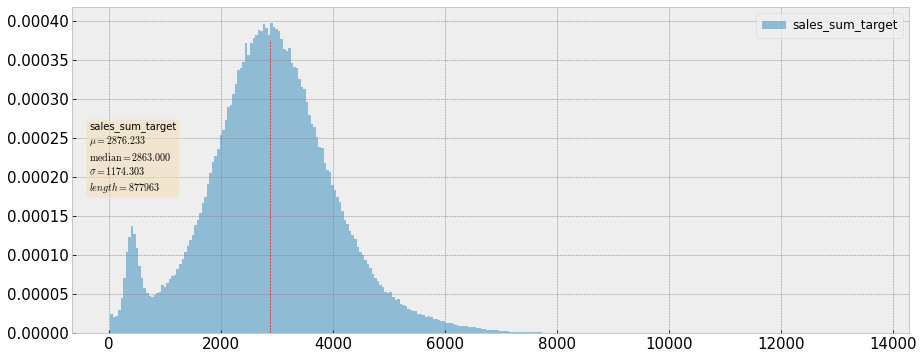

,effects,sample_size,calc_method
0,1.01,24738,complex
1,1.02,6185,complex
2,1.03,2749,complex
3,1.04,1547,complex
4,1.05,990,complex
5,1.06,688,complex
6,1.07,505,complex
7,1.08,387,complex
8,1.09,306,complex
9,1.10,248,complex


,sample_size,effect_abs,effect_percent
0,1000,202.309568,7.033838
1,1500,165.185070,5.743105
2,2000,143.054467,4.973675
3,2500,127.951805,4.448590
4,3000,116.803483,4.060988
5,3500,108.139013,3.759745
6,4000,101.154784,3.516919
7,4500,95.369645,3.315783
8,5000,90.475589,3.145628
9,5500,86.265090,2.999239


Детектируем эффект в 1.0 % или 29.0 единиц в абсолютном выражении
    Размер выборки: 24738
Запуск A/A/B теста...


  0%|          | 0/5000 [00:00<?, ?it/s]

Оценка вероятности ошибки I рода = 0.0496
    Доверительный интервал = [0.0436, 0.0556]
Оценка вероятности ошибки II рода = 0.2184
    Доверительный интервал = [0.2069, 0.2299]


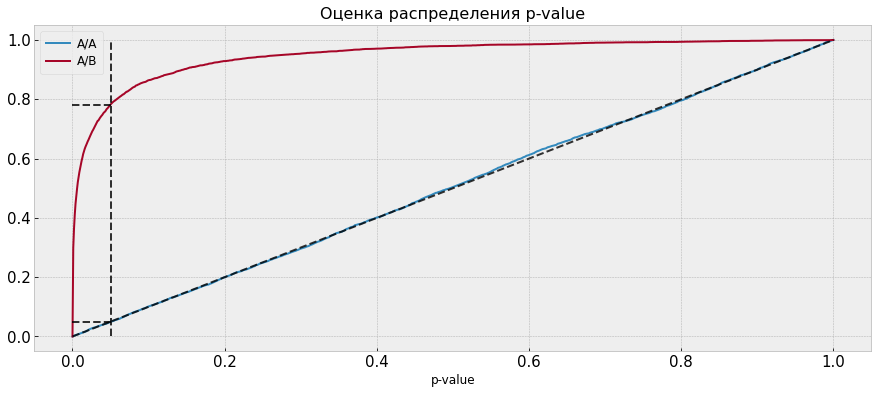

    Подбор контрольной и тестовой групп...
Done!
Time elapsed (hh:mm:ss.ms) 0:03:48.884803


In [5]:
control_pilot_groups = ab_exp.design_test(sales, users, ['day'])

In [9]:
control_pilot_groups['user_id'].nunique()

49468

In [12]:
control_pilot_groups[control_pilot_groups['group']=='control']['user_id'].nunique()

24734

In [13]:
control_pilot_groups[control_pilot_groups['group']=='pilot']['user_id'].nunique()

24734

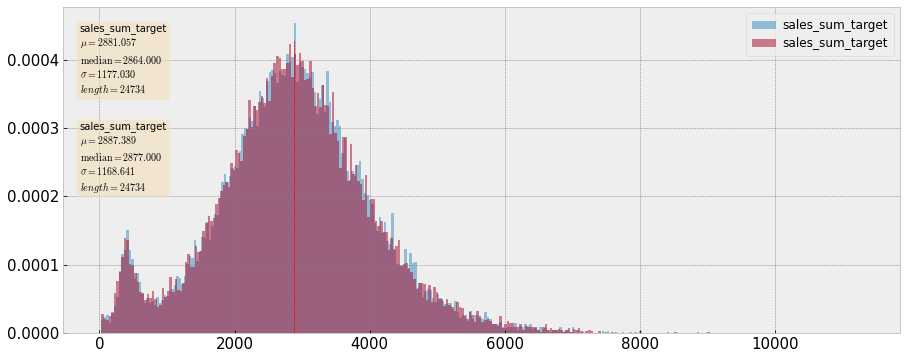

In [17]:
m1 = control_pilot_groups[control_pilot_groups['group']=='pilot']['sales_sum_target']
m2 = control_pilot_groups[control_pilot_groups['group']=='control']['sales_sum_target']
ab_exp.data_distribution_plot([m1, m2])

In [ ]:
# TEST

In [18]:
design_users = control_pilot_groups['user_id']

In [19]:
experiment_period_ = sales_[sales_['day'].between(8, 14)]
experiment_period_users = experiment_period_[experiment_period_['user_id'].isin(design_users)]

In [20]:
experiment_period_users.head()

,user_id,day,sales
1599,8460048,8,191
1600,8460048,8,106
1601,8460048,8,182
1602,8460048,9,552
1603,8460048,10,419


In [21]:
# Оставляем только тех пользователей, которые участвуют в эксперименте
# Для тех, кто не выжил в эксперименте, проставляем 0
experiment_period_groups = pd.merge(
    control_pilot_groups[['user_id', 'group']],
    experiment_period_users, 
    how='left', 
    on='user_id'
).fillna(0)
experiment_period_groups['period'] = 'pilot'

In [22]:
experiment_period_groups.head()

,user_id,group,day,sales,period
0,2320133,control,8.0,161.0,pilot
1,2320133,control,8.0,212.0,pilot
2,2320133,control,9.0,141.0,pilot
3,2320133,control,9.0,234.0,pilot
4,2320133,control,10.0,213.0,pilot


In [23]:
print(experiment_period_groups[experiment_period_groups['group']=='control']['user_id'].nunique())
print(experiment_period_groups[experiment_period_groups['group']=='pilot']['user_id'].nunique())

24734
24734


In [24]:
column_for_grouped, exp_ness_cols = ab_exp.get_grouped_columns(experiment_period_groups, design_dict['metric_dict'], ['day'])

In [25]:
exp_ness_cols.head()

,user_id,group,period,sales
0,2320133,control,pilot,161.0
1,2320133,control,pilot,212.0
2,2320133,control,pilot,141.0
3,2320133,control,pilot,234.0
4,2320133,control,pilot,213.0


In [26]:
exp_agg_df, kappa_dict = ab_exp.calc_metrics(
    exp_ness_cols, 
    design_dict['metric_dict'], 
    column_for_grouped, 
    kappa=None, 
    is_history_data=False)

In [27]:
kappa_dict

{}

In [28]:
exp_agg_df.head()

,user_id,group,period,sales_sum_target,sales_ratio_help
0,1000272,pilot,pilot,1215.0,135.000000
1,1000367,pilot,pilot,2648.0,54.040816
2,1000630,control,pilot,2115.0,43.163265
3,1000658,pilot,pilot,337.0,337.000000
4,1000696,control,pilot,1368.0,342.000000


In [50]:
eff = 30
m1 = exp_agg_df[exp_agg_df['group']=='control']['sales_sum_target']
m2 = exp_agg_df[exp_agg_df['group']=='pilot']['sales_sum_target'] + eff

In [51]:
ab_exp.absolute_ttest(m1, m2)

ExperimentComparisonResults(pvalue=0.02105439616234819, effect=28.683310422899467, ci_length=48.736948478445015, left_bound=4.314836183676956, right_bound=53.051784662121975)

In [54]:
ab_exp.simple_ttest(m1, m2)

0.021061105890033703

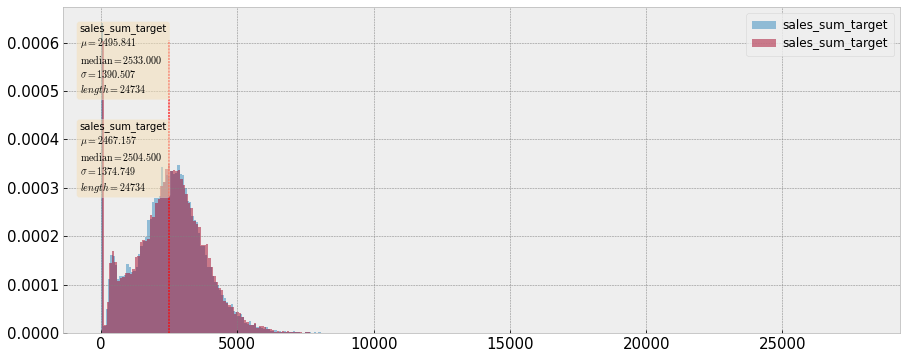

In [52]:
ab_exp.data_distribution_plot([m1, m2])

In [55]:
cuped = ab_exp.calculate_metric_cuped(control_pilot_groups, exp_agg_df, 'user_id', 'sales_sum_target')

Theta is:  0.667110093631703


In [56]:
print(np.var(cuped[cuped['group']=='control']['sales_sum_target']))
print(np.var(cuped[cuped['group']=='pilot']['sales_sum_target']))

1385398.670201215
1365722.3733579528


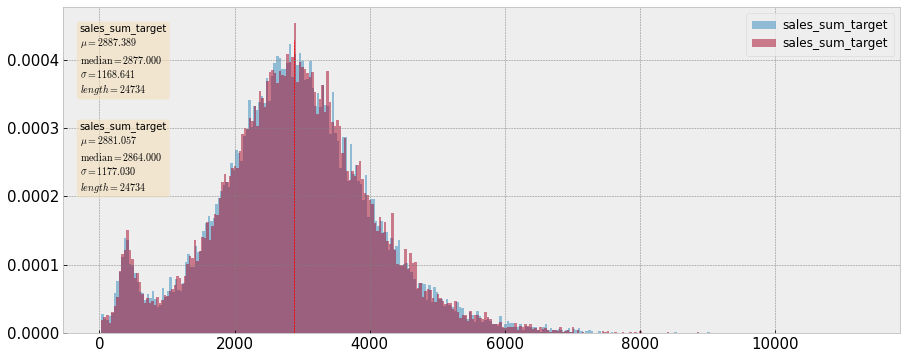

In [61]:
ab_exp.data_distribution_plot(
    [
        cuped[cuped['group']=='control']['sales_sum_target'],
        cuped[cuped['group']=='pilot']['sales_sum_target']
        ]
    )

In [62]:
1177.03 / 1390.5

0.8464796835670622

In [60]:
ab_exp.simple_ttest(
    cuped[cuped['group']=='control']['sales_sum_target'],
    cuped[cuped['group']=='pilot']['sales_sum_target'] + 15
)

0.04311362964313072

In [63]:
ab_exp.absolute_ttest(
    cuped[cuped['group']=='control']['sales_sum_target'],
    cuped[cuped['group']=='pilot']['sales_sum_target'] + 15
)

ExperimentComparisonResults(pvalue=0.043104041699992615, effect=21.332376485809164, ci_length=41.341455044100144, left_bound=0.6616489637590917, right_bound=42.003104007859235)